In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial

In [2]:
# Create a sample time series with returns
def generate_random_series():
    index = pd.date_range('2023-01-01', periods=100, freq='D')
    returns = pd.Series(np.random.randn(100) * 0.01, index=index)
    # returns = pd.Series(np.random.standard_t(df=100, size=100))
    cumulative = (1 + returns).cumprod() - 1

    return cumulative

#### 1. Sampling for reduction
What conditions should preceed the algorithms training data

In [4]:
# 1. CUMSUM filter - when a cumulative price movement has taken place
# 2. Tight volatility range - consolidation period leads to bigger move
def inverse_cumsum_filter(series: pd.Series, h: float, n: int) -> pd.Series:
    """
    Apply a cumulative sum filter to a time series based on a rolling period.
    
    Parameters:
    - series: pd.Series, time series of returns with time stamp index
    - h: float, threshold value for filtering
    - n: int, lookback period for the rolling window
    
    Returns:
    - pd.Series, boolean series where True indicates dates flagged by the filter
    """
    # Ensure the series is sorted by index (time)
    series = series.sort_index()
    
    # Calculate the rolling cumulative sum over the lookback period n
    rolling_cumsum = series.rolling(window=n).sum()
    
    # Flag dates where the cumulative return is less than the absolute value of h
    flagged = (rolling_cumsum.abs() < h)
    
    return flagged

import matplotlib.pyplot as plt

def plot_with_flags(series: pd.Series, flagged: pd.Series):
    """
    Plots a time series and highlights flagged dates as red dots.
    
    Parameters:
    - series: pd.Series, the original time series of returns with timestamp index
    - flagged: pd.Series, boolean series indicating flagged dates
    """
    # Ensure the series is sorted by time index
    series = series.sort_index()

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Time Series', color='blue')

    # Highlight flagged dates as red dots
    plt.scatter(series.index[flagged], series.values[flagged], color='red', label='Flagged Dates')

    # Add labels and legend
    plt.title(f"Time Series with Flagged Dates; Percent labels = {np.average(flagged)*100}%")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


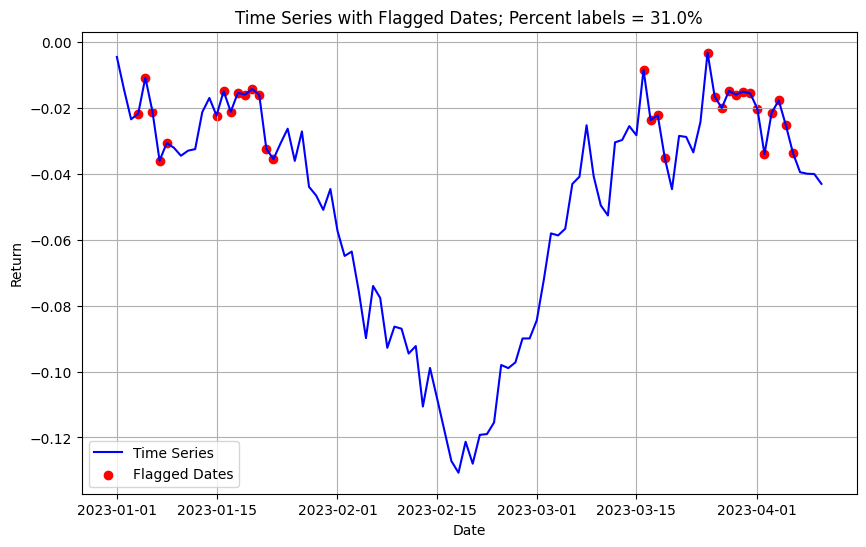

In [13]:
# Apply the cumsum_filter with a threshold h and a lookback period n
cumulative = generate_random_series()

h = 0.1
n = 4
flagged_dates = inverse_cumsum_filter(cumulative, h, n)
percent_labels = np.average(flagged_dates)*100

plot_with_flags(series = cumulative, flagged = flagged_dates)

In [7]:
def generate_percent_label_matrix(samples: int = 100):
    """
    Generate a matrix of % label values for different combinations of h and n.
    
    h ranges from 0.01 to 0.2 with a step of 0.01.
    n ranges from 3 to 30 with a step of 1.
    The % label is based on an average of 100 random series.
    
    Returns:
    - pd.DataFrame, with rows as n values and columns as h values, containing % label values.
    """
    # Range of h values from 0.01 to 0.2 with step 0.01
    h_values = np.arange(0.01, 0.21, 0.01)
    # Range of n values from 3 to 30 with step 1
    n_values = np.arange(3, 31, 1)
    
    # Initialize an empty matrix to store % label values
    percent_label_matrix = np.zeros((len(n_values), len(h_values)))

    # Perform calculations
    for i, n in enumerate(n_values):
        for j, h in enumerate(h_values):
            # Average percent labels over 100 random series
            percent_labels = []
            for _ in range(samples):  # Generate 100 random series
                cumulative = generate_random_series()  # Generate random return series
                flagged_dates = inverse_cumsum_filter(cumulative, h, n)  # Apply filter
                percent_labels.append(np.average(flagged_dates) * 100)  # Calculate % flagged
            
            # Store the average % label in the matrix
            percent_label_matrix[i, j] = np.mean(percent_labels)
    
    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(percent_label_matrix, index=n_values, columns=h_values)
    
    return percent_label_df

def plot_percent_label_matrix(matrix: pd.DataFrame, threshold: float = 20):
    """
    Visualize the percent label matrix using a heatmap.
    
    Parameters:
    - matrix: pd.DataFrame, matrix of % label values where rows are n values and columns are h values
    """
    # Create a mask for values less than the threshold
    mask = matrix < threshold
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, mask=mask, annot=True, cmap="YlGnBu", cbar_kws={'label': '% Label'}, 
                vmin=threshold, linewidths=0.5, linecolor='gray')
    
    # Set the labels and title
    plt.title('Heatmap of % Label Values for Different n and h')
    plt.xlabel('h (Threshold)')
    plt.ylabel('n (Lookback Period)')
    
    # Show the plot
    plt.show()

In [8]:
# Assuming percent_label_matrix is the output from generate_percent_label_matrix()
percent_label_matrix = generate_percent_label_matrix(1000)

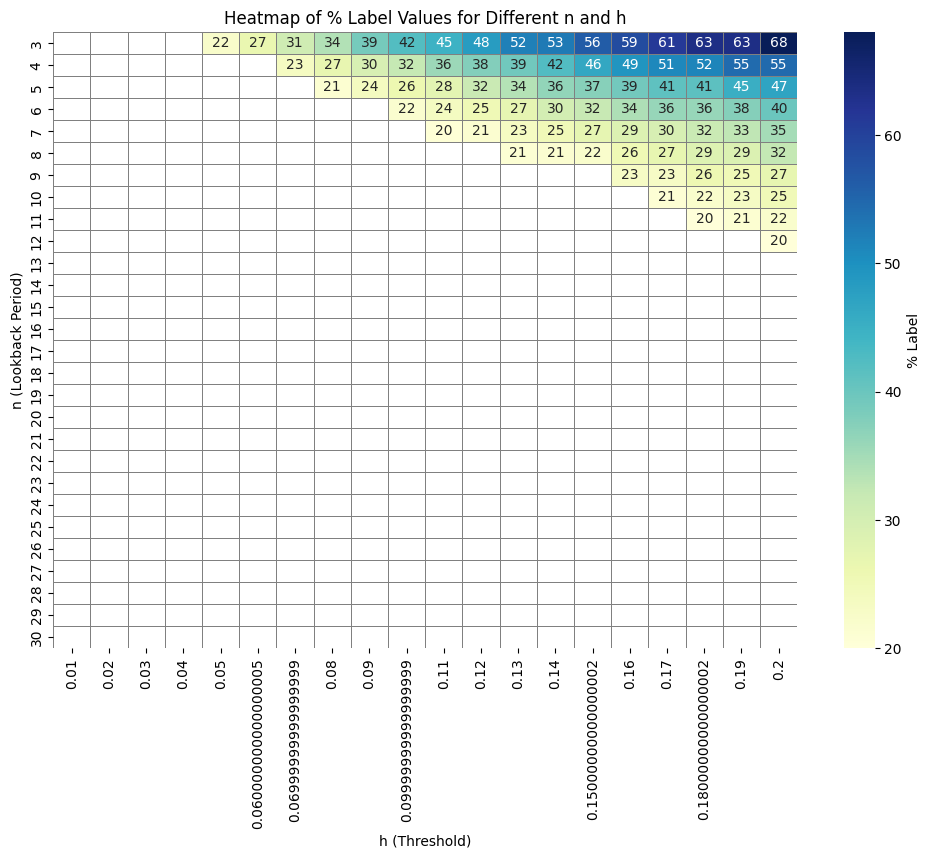

In [9]:
# Visualize the matrix
plot_percent_label_matrix(percent_label_matrix)
